# 타이타닉 생존자 예측하기

## 1. 데이터 전처리

In [623]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv('C:/Users/windows/Desktop/python/Dataset/Titanic-Dataset.csv')

In [624]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 결측치 다루기
- Week1 과제에서 타이타닉 데이터 전처리 할 때 이상치는 없었음 -> 결측치만 처리하기로 결정.

In [625]:
data.isna().sum() # Age, Cabin, Embarked에 결측치가 존재함

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### 1. Embarked (결측치 2개)

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


<Axes: xlabel='Embarked', ylabel='count'>

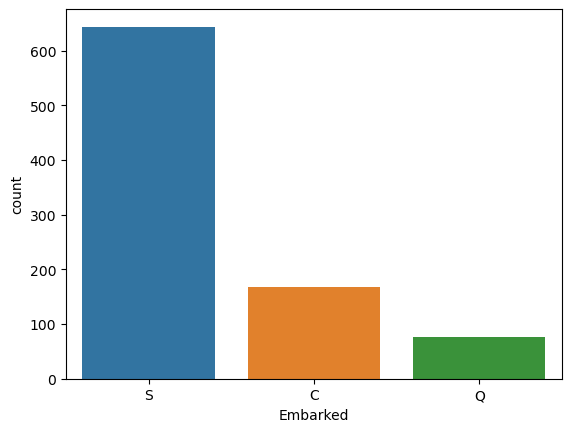

In [626]:
print(data["Embarked"].value_counts())
sns.countplot(x=data["Embarked"])

In [627]:
data[data['Embarked'].isna()] 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


- 동행한 가족이 있다면 그 가족의 탑승 항구로 결측치를 채우려고 했으나 두 사람 모두 동행한 가족 없음 -> 가장 빈도가 높은 S로 대체

In [628]:
df= data.copy()

In [629]:
df['Embarked'].fillna('S', inplace=True) 

#### 2. Age(결측치 177개)

- 머신러닝을 통해 Age 결측값을 예측
- Age가 비어있지 않은 행들로 train , 비어있는 행들을 test 

In [630]:
from sklearn.ensemble import RandomForestRegressor

# Age가 비어있지 않은 데이터로 학습, 비어있는 행들로 test
train = df.dropna(subset=['Age'])
test = df[df['Age'].isnull()]

In [631]:
# 사용할 특성 선택
features = ['Pclass', 'SibSp', 'Parch', 'Fare']  # Age와 상관 높을 것 같은 특성들 선택
X_train = train[features]
y_train = train['Age']
X_test = test[features]

In [632]:
# 모델 학습
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=2025))
model.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=2025))])

In [633]:
y_train_pred = model.predict(X_train) #학습에 사용한 데이터

In [634]:
from sklearn.metrics import r2_score, mean_squared_error

In [635]:
print('학습 능력')
print('R Square : ', r2_score(y_train, y_train_pred))
print('MSE : ', mean_squared_error(y_train, y_train_pred))

학습 능력
R Square :  0.6455548336972581
MSE :  74.68995426969732


In [636]:
# 예측값 채우기
df.loc[df['Age'].isnull(), 'Age'] = model.predict(X_test)

In [637]:
df.isna().sum() # Age에 결측치 다 채워짐 !!

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

#### 3. Cabin(결측치 687개)

- 결측치가 너무 많음
- 범주형 변수이고 범주가 다양해서 채워넣기 어려움
- 제거하기로 결정

In [638]:
df['Cabin'].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [639]:
df = df.drop(columns=['Cabin'])

In [640]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [641]:
df.isna().sum() # 결측치 처리 완료

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## 데이터 인코딩

- Sex : male/female -> 0,1 로 레이블 인코딩
- Embarked : S/C/Q -> 원-핫 인코딩

In [642]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df['Sex'] = LE.fit_transform(df['Sex'])
df['Sex'].head() # 1: male, 0: female

0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int32

In [643]:
from sklearn.preprocessing import OneHotEncoder

embarked = df[['Embarked']]

encoder = OneHotEncoder(drop='first', sparse=False)  # drop='first' : 첫 번째 카테고리 제거

# 원핫인코딩 수행
encoded_embarked = encoder.fit_transform(embarked)

# 원핫인코딩된 결과는 numpy -> 다시 DataFrame으로 변환
encoded_embarked_df = pd.DataFrame(encoded_embarked, columns=encoder.get_feature_names_out(['Embarked']))

# 원본 데이터에 원핫인코딩된 결과 추가
df = df.join(encoded_embarked_df)

c:\Users\windows\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [644]:
# 결과 출력
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S,0.0,1.0


In [645]:
df = df.drop(columns=['Embarked'])

In [646]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0.0,1.0


In [647]:
# Name, Ticket은 고유 값들로 이루어져있고 분석에 큰 영향을 미치지 않을 것 같아 제거하기로 결정. 

In [648]:
df = df.drop(columns=['Name', 'Ticket'])

In [649]:
df.head()
df.tail()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
886,887,0,2,1,27.000000,0,0,13.00,0.0,1.0
887,888,1,1,0,19.000000,0,0,30.00,0.0,1.0
888,889,0,3,0,16.753333,1,2,23.45,0.0,1.0
889,890,1,1,1,26.000000,0,0,30.00,0.0,0.0
890,891,0,3,1,32.000000,0,0,7.75,1.0,0.0


## 2. 타이타닉 생존자 예측

1. 학습 / 예측 데이터셋 나누기


In [650]:
X = df.drop(columns=['Survived'])
y = df['Survived']

In [651]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2025)

2. 그리드 서치로 모델 학습

In [652]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 300],       # 트리의 개수
    'max_depth': [5, 10, 15],          # 트리의 최대 깊이
    'min_samples_split': [2, 5, 10],         # 노드를 분할하는 데 필요한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]            # 리프 노드에 있어야 하는 최소 샘플 수
}

# GridSearchCV 설정
clf = RandomForestClassifier(random_state=2025)
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid, 
                           cv=6, 
                           scoring='accuracy', 
                           n_jobs=-1, 
                           verbose=2)

# 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 교차검증 점수 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최적 교차검증 점수: {:.4f}".format(grid_search.best_score_))



Fitting 6 folds for each of 81 candidates, totalling 486 fits
최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
최적 교차검증 점수: 0.8458


In [653]:
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

from sklearn.metrics import accuracy_score

# 모델 성능 확인
print('학습 정확도 : ', accuracy_score(y_train, y_train_pred)) 
print('검증 정확도 : ', accuracy_score(y_test, y_test_pred))  

학습 정확도 :  0.9491017964071856
검증 정확도 :  0.7982062780269058


In [654]:
best_model.feature_importances_

array([0.13367525, 0.10830857, 0.30662748, 0.16020332, 0.04953081,
       0.03243645, 0.1840103 , 0.00905571, 0.01615211])

<Axes: >

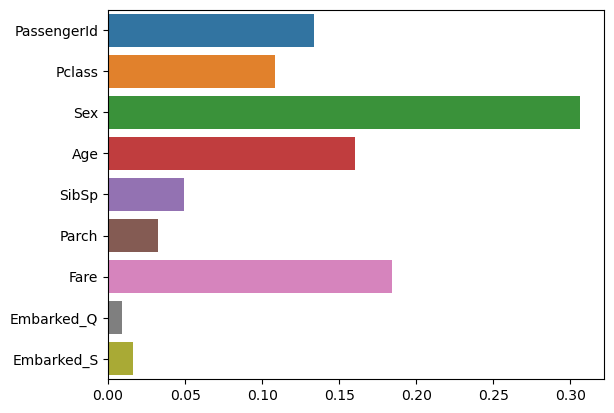

In [655]:
sns.barplot(x=best_model.feature_importances_, y=X.columns)

---

# 따릉이 대여량 예측하기

## 1. 데이터 전처리

In [656]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기기
data_train=pd.read_csv('C:/Users/windows/Desktop/python/Dataset/train.csv')
data_test = pd.read_csv('C:/Users/windows/Desktop/python/Dataset/test.csv')

In [657]:
data_train.head(10)

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.00,0.0,0.0,NaN,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.00,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.00,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.00,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,NaN,2000,-18.6,0.00,0.0,0.0,Winter,No Holiday,Yes
5,01/12/2017,100,5,-6.4,37,1.5,2000,-18.7,0.00,0.0,0.0,Winter,No Holiday,Yes
6,01/12/2017,181,6,NaN,35,1.3,2000,-19.5,0.00,0.0,0.0,Winter,No Holiday,Yes
7,01/12/2017,460,7,-7.4,38,0.9,2000,-19.3,0.00,0.0,0.0,Winter,No Holiday,Yes
8,01/12/2017,930,8,NaN,37,1.1,2000,-19.8,0.01,0.0,0.0,Winter,No Holiday,Yes
9,01/12/2017,490,9,-6.5,27,0.5,1928,-22.4,0.23,0.0,0.0,Winter,No Holiday,Yes


In [658]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040 entries, 0 to 8039
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8040 non-null   object 
 1   Rented Bike Count          8040 non-null   int64  
 2   Hour                       8040 non-null   int64  
 3   Temperature(째C)            7240 non-null   float64
 4   Humidity(%)                8040 non-null   int64  
 5   Wind speed (m/s)           7238 non-null   float64
 6   Visibility (10m)           8040 non-null   int64  
 7   Dew point temperature(째C)  8040 non-null   float64
 8   Solar Radiation (MJ/m2)    8040 non-null   float64
 9   Rainfall(mm)               8040 non-null   float64
 10  Snowfall (cm)              8040 non-null   float64
 11  Seasons                    7238 non-null   object 
 12  Holiday                    8040 non-null   object 
 13  Functioning Day            8040 non-null   objec

In [659]:
data_train.isna().sum() # Temperature, Wind speed, seasons 에 결측치가 존재함

Date                           0
Rented Bike Count              0
Hour                           0
Temperature(째C)              800
Humidity(%)                    0
Wind speed (m/s)             802
Visibility (10m)               0
Dew point temperature(째C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                      802
Holiday                        0
Functioning Day                0
dtype: int64

In [660]:
data_train.describe()

,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8040.000000,8040.000000,7240.000000,8040.000000,7238.000000,8040.000000,8040.000000,8040.000000,8040.000000,8040.000000
mean,709.775995,11.500000,13.498564,58.271020,1.756756,1459.170896,4.522239,0.587072,0.152164,0.066493
std,657.320605,6.922617,12.270471,20.340492,1.045901,603.716284,13.393517,0.886186,1.127026,0.378182
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,43.000000,1.000000,977.000000,-4.600000,0.000000,0.000000,0.000000
50%,485.000000,11.500000,15.600000,57.000000,1.600000,1741.000000,6.400000,0.020000,0.000000,0.000000
75%,1080.500000,17.250000,23.300000,74.000000,2.400000,2000.000000,15.600000,0.960000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,5.100000


### 변수 별로 확인 -> 시각화 & 이상치, 결측치 처리, 인코딩

- Date
- 모든 날짜가 24개의 빈도를 동일하게 가지고 있음 (최솟값도 24, 최댓값도 24) -> 이상치 처리할 필요 없다고 판단

In [661]:
data_train['Date'].value_counts()
data_train['Date'].value_counts().min() #24
data_train['Date'].value_counts().max() #24

24

---

- Rented Bike Count

<Axes: xlabel='Rented Bike Count'>

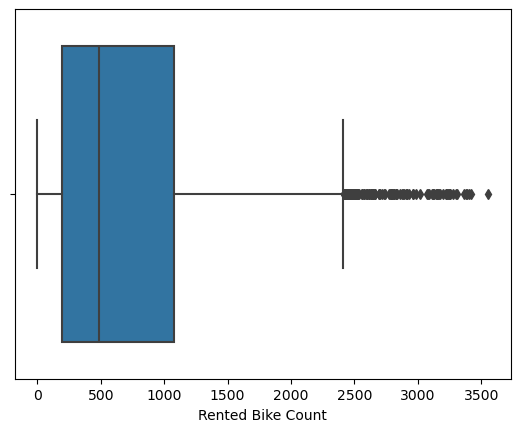

In [662]:
sns.boxplot(x=data_train['Rented Bike Count'])

In [663]:
print(data_train['Rented Bike Count'].min())
print(data_train['Rented Bike Count'].max())

0
3556


c:\Users\windows\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Rented Bike Count', ylabel='Count'>

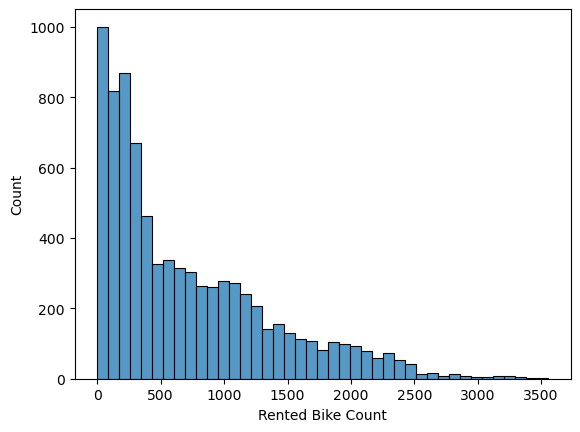

In [664]:
sns.histplot(x=data_train['Rented Bike Count'])

In [665]:
data_train['Rented Bike Count'].value_counts()

Rented Bike Count
0       223
103      18
223      18
262      18
165      17
       ... 
2191      1
1970      1
3113      1
2602      1
1907      1
Name: count, Length: 2138, dtype: int64

---

- Hour

In [666]:
data_train['Hour'].value_counts() #이상치, 결측치 없음     

Hour
0     335
1     335
22    335
21    335
20    335
19    335
18    335
17    335
16    335
15    335
14    335
13    335
12    335
11    335
10    335
9     335
8     335
7     335
6     335
5     335
4     335
3     335
2     335
23    335
Name: count, dtype: int64

<Axes: xlabel='Hour', ylabel='Rented Bike Count'>

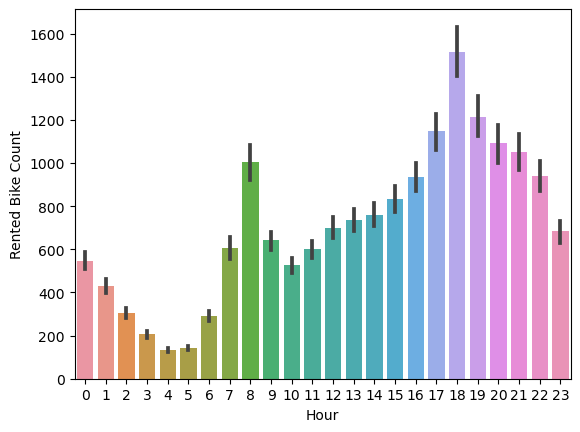

In [667]:
# 시간과 따릉이 대여량 관계 확인
sns.barplot(data=data_train, x="Hour", y="Rented Bike Count") #8,17~20시가 대여량 많음 -> 출퇴근 시 따릉이 사용하는 것으로 예측됨

---

- Seasons

- 계절이 바뀌는 경계를 확인해보니 월별로 계절을 구분한 것을 알 수 있음
- 12/1/2->Winter, 3/4/5-> Spring, 6/7/8 ->Summer, 9,10 -> Autumn(11월은 데이터에 존재하지 않음)
- Date의 월에 따라서 Seasons의 결측치를 채움
- 원핫인코딩 방식으로 수치화

In [668]:
data_train['Seasons'].value_counts()

Seasons
Spring    1990
Summer    1990
Winter    1935
Autumn    1323
Name: count, dtype: int64

In [669]:
data_train.head()

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,NaN,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,NaN,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [670]:
data_train.tail()

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
8035,31/10/2018,1507,19,8.4,53,NaN,2000,-0.6,0.0,0.0,0.0,Autumn,No Holiday,Yes
8036,31/10/2018,1176,20,7.6,59,0.7,2000,0.0,0.0,0.0,0.0,NaN,No Holiday,Yes
8037,31/10/2018,1069,21,7.6,59,3.0,1929,0.0,0.0,0.0,0.0,Autumn,No Holiday,Yes
8038,31/10/2018,1088,22,6.8,58,2.2,1936,-0.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8039,31/10/2018,798,23,6.4,60,1.8,1930,-0.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [671]:
data_train.loc[2150:2180] # 월을 기준으로 계절을 나누었는지 확인하고 싶음 -> 2월 말, 3월 초의 계절을 확인하기로함
# 2월 까지는  Winter, 3월부터는 Spring

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
2150,28/02/2018,17,14,NaN,80,3.7,348,2.5,0.13,0.0,0.0,Winter,No Holiday,Yes
2151,28/02/2018,7,15,NaN,87,NaN,312,2.8,0.08,4.5,0.0,Winter,No Holiday,Yes
2152,28/02/2018,9,16,4.2,89,2.5,479,2.5,0.07,0.0,0.0,Winter,No Holiday,Yes
2153,28/02/2018,8,17,NaN,90,2.7,654,2.3,0.00,0.0,0.0,Winter,No Holiday,Yes
2154,28/02/2018,11,18,3.6,90,2.1,845,2.1,0.00,9.5,0.0,Winter,No Holiday,Yes
2155,28/02/2018,19,19,2.5,95,NaN,838,1.7,0.00,0.0,0.0,Winter,No Holiday,Yes
2156,28/02/2018,8,20,2.7,96,1.5,1479,2.1,0.00,0.0,0.0,Winter,No Holiday,Yes
2157,28/02/2018,10,21,2.4,95,2.5,1349,1.6,0.00,9.0,0.0,Winter,No Holiday,Yes
2158,28/02/2018,13,22,2.3,96,1.9,1207,1.7,0.00,0.0,0.0,Winter,No Holiday,Yes
2159,28/02/2018,23,23,1.8,96,1.2,745,1.2,0.00,0.0,0.0,Winter,No Holiday,Yes


In [672]:
data_train.loc[4350:4390] #5월까지 Spring, 6월부터 Summer

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
4350,31/05/2018,646,6,14.3,82,0.7,653,11.2,0.05,0.0,0.0,NaN,No Holiday,Yes
4351,31/05/2018,1401,7,14.9,71,0.9,651,9.6,0.47,0.0,0.0,NaN,No Holiday,Yes
4352,31/05/2018,2281,8,16.9,65,1.6,896,10.2,1.21,0.0,0.0,Spring,No Holiday,Yes
4353,31/05/2018,1277,9,18.8,59,1.6,1233,10.6,1.90,0.0,0.0,Spring,No Holiday,Yes
4354,31/05/2018,936,10,20.8,54,1.2,1129,11.1,2.45,0.0,0.0,Spring,No Holiday,Yes
4355,31/05/2018,979,11,NaN,54,2.7,1189,12.2,2.89,0.0,0.0,Spring,No Holiday,Yes
4356,31/05/2018,1134,12,23.7,44,1.3,1624,10.7,3.20,0.0,0.0,NaN,No Holiday,Yes
4357,31/05/2018,1151,13,NaN,47,2.5,1120,12.8,3.34,0.0,0.0,Spring,No Holiday,Yes
4358,31/05/2018,1164,14,25.9,43,2.7,1493,12.3,2.97,0.0,0.0,Spring,No Holiday,Yes
4359,31/05/2018,1280,15,26.9,37,2.7,1850,10.9,2.90,0.0,0.0,Spring,No Holiday,Yes


In [673]:
data_train.loc[6570:6580] #8월까지 Summer, 9월부터 Autumn

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
6570,31/08/2018,2836,18,28.4,57,2.4,2000,19.0,0.84,0.0,0.0,Summer,No Holiday,Yes
6571,31/08/2018,2372,19,NaN,69,2.3,2000,20.3,0.18,0.0,0.0,Summer,No Holiday,Yes
6572,31/08/2018,1995,20,25.4,74,1.6,2000,20.4,0.00,0.0,0.0,Summer,No Holiday,Yes
6573,31/08/2018,1931,21,NaN,78,1.2,2000,20.4,0.00,0.0,0.0,Summer,No Holiday,Yes
6574,31/08/2018,1789,22,24.1,80,0.9,1852,20.4,0.00,0.0,0.0,NaN,No Holiday,Yes
6575,31/08/2018,1329,23,23.8,81,0.6,1893,20.3,0.00,0.0,0.0,Summer,No Holiday,Yes
6576,01/09/2018,1075,0,23.2,83,0.5,1887,20.1,0.00,0.0,0.0,Autumn,No Holiday,Yes
6577,01/09/2018,975,1,22.7,83,0.1,1940,19.6,0.00,0.0,0.0,Autumn,No Holiday,Yes
6578,01/09/2018,785,2,22.0,86,0.4,1703,19.5,0.00,0.0,0.0,Autumn,No Holiday,Yes
6579,01/09/2018,514,3,21.6,87,NaN,1579,19.3,0.00,0.0,0.0,Autumn,No Holiday,Yes


In [674]:
# 월에 따라서 결측치 채우기

df = data_train.copy()
# 날짜 형식 변환
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

# 월(month) → 계절(Seasons) 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9,10]:
        return 'Autumn'
    elif month in [12, 1, 2]:
        return 'Winter'

# Seasons가 결측치(NaN)인 경우에만 채우기
df['Seasons'] = df['Seasons'].fillna(df['Date'].dt.month.apply(get_season))

# 결과 확인
df['Seasons'].isna().sum()


0

In [675]:
# 원핫인코딩 진행

# 라이브러리 불러오기기
from sklearn.preprocessing import OneHotEncoder

# OneHotEncoder 생성
ohe = OneHotEncoder(sparse=False)

# Seasons 변수 원핫인코딩
seasons_encoded = ohe.fit_transform(df[['Seasons']])

# 변환된 데이터프레임으로 변환
seasons_df = pd.DataFrame(seasons_encoded, columns=ohe.get_feature_names_out(['Seasons']))

# 기존 데이터프레임에 추가
df = pd.concat([df, seasons_df], axis=1)

# 기존 'Seasons' 변수 삭제
df.drop(columns=['Seasons'], inplace=True)

# 결과 확인
df.head()


c:\Users\windows\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,No Holiday,Yes,0.0,0.0,0.0,1.0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,No Holiday,Yes,0.0,0.0,0.0,1.0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,No Holiday,Yes,0.0,0.0,0.0,1.0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,No Holiday,Yes,0.0,0.0,0.0,1.0
4,2017-12-01,78,4,-6.0,36,NaN,2000,-18.6,0.0,0.0,0.0,No Holiday,Yes,0.0,0.0,0.0,1.0


<Axes: xlabel='Seasons', ylabel='Rented Bike Count'>

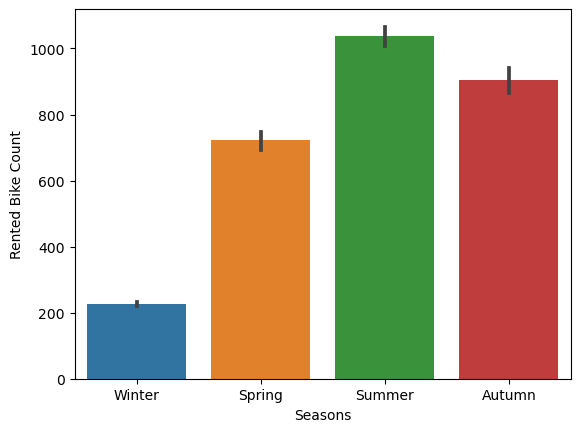

In [676]:
sns.barplot(data=data_train, x="Seasons", y="Rented Bike Count")

-------

- Temperature(째C)
- 800개 결측치 존재

In [677]:
# 계절 별 평균 기온 확인하기

print(df.groupby('Seasons_Autumn')['Temperature(째C)'].mean()) #17.274578
print(df.groupby('Seasons_Spring')['Temperature(째C)'].mean()) #13.147726
print(df.groupby('Seasons_Summer')['Temperature(째C)'].mean()) #26.610258
print(df.groupby('Seasons_Winter')['Temperature(째C)'].mean()) #-2.485670

Seasons_Autumn
0.0    12.670613
1.0    17.274578
Name: Temperature(째C), dtype: float64
Seasons_Spring
0.0    13.632563
1.0    13.147726
Name: Temperature(째C), dtype: float64
Seasons_Summer
0.0     8.431655
1.0    26.610258
Name: Temperature(째C), dtype: float64
Seasons_Winter
0.0    19.263221
1.0    -2.485670
Name: Temperature(째C), dtype: float64


In [678]:
# 계절별 평균 온도
season_avg_temp = df.groupby(['Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter'])['Temperature(째C)'].mean()

# 결측치를 계절별 평균 온도로 채우기
def fill_missing_temp(row):
    if pd.isnull(row['Temperature(째C)']):  # 온도가 결측치라면
        return season_avg_temp.loc[(row['Seasons_Autumn'], row['Seasons_Spring'], row['Seasons_Summer'], row['Seasons_Winter'])]
    else:
        return row['Temperature(째C)']

df['Temperature(째C)'] = df.apply(fill_missing_temp, axis=1)

#확인
df['Temperature(째C)'].isna().sum()


0

<Axes: xlabel='Temperature(째C)', ylabel='Rented Bike Count'>

c:\Users\windows\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from current font.
  func(*args, **kwargs)
c:\Users\windows\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


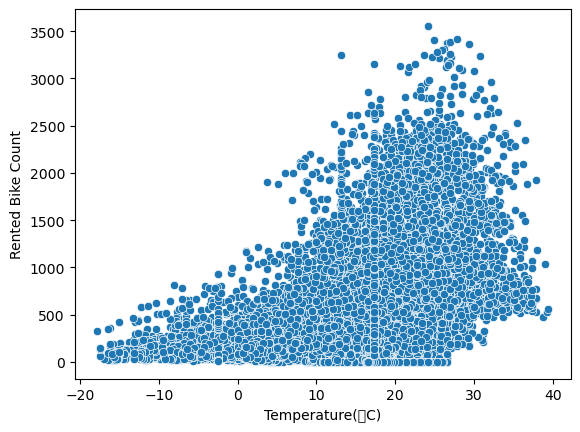

In [679]:
# 온도와 따릉이 대여량 관계
sns.scatterplot(data=df, x="Temperature(째C)", y="Rented Bike Count")

---

- Humidity(%)
- 우리나라에서 기록된 가장 낮은 상대습도는 5~10% 정도->0%는 물리적으로 거의 불가능함 -> 이상치 처리

c:\Users\windows\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Humidity(%)', ylabel='Count'>

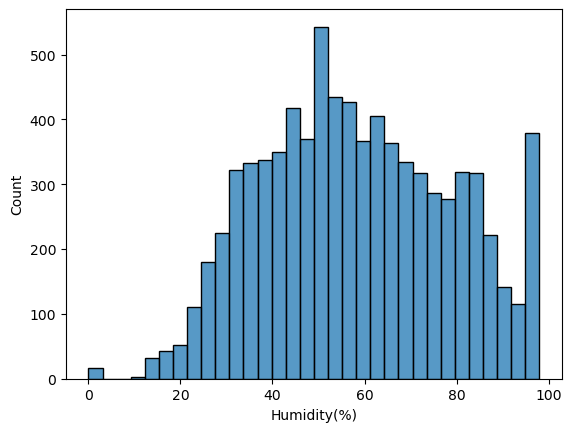

In [680]:
sns.histplot(x=df['Humidity(%)'])

In [681]:
df['Humidity(%)'].min()

0

In [682]:
df[df['Humidity(%)']==0] #확인해보니 Humidity가 0인 데이터는 모두 Spring 

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter
4063,2018-05-19,436,7,11.400000,0,1.4,2000,4.5,0.46,0.0,0.0,No Holiday,Yes,0.0,1.0,0.0,0.0
4106,2018-05-21,262,2,13.900000,0,0.9,2000,-2.1,0.00,0.0,0.0,No Holiday,Yes,0.0,1.0,0.0,0.0
4107,2018-05-21,165,3,13.000000,0,0.8,2000,-2.5,0.00,0.0,0.0,No Holiday,Yes,0.0,1.0,0.0,0.0
4108,2018-05-21,113,4,12.400000,0,0.8,2000,-3.4,0.00,0.0,0.0,No Holiday,Yes,0.0,1.0,0.0,0.0
4109,2018-05-21,200,5,11.900000,0,1.3,2000,-2.7,0.00,0.0,0.0,No Holiday,Yes,0.0,1.0,0.0,0.0
4110,2018-05-21,467,6,11.400000,0,0.9,2000,-2.0,0.03,0.0,0.0,No Holiday,Yes,0.0,1.0,0.0,0.0
4111,2018-05-21,1135,7,12.300000,0,NaN,1989,-2.7,0.48,0.0,0.0,No Holiday,Yes,0.0,1.0,0.0,0.0
4131,2018-05-22,406,3,13.147726,0,0.7,1420,10.4,0.00,0.0,0.0,Holiday,Yes,0.0,1.0,0.0,0.0
4132,2018-05-22,248,4,15.600000,0,0.5,1502,10.5,0.00,0.0,0.0,Holiday,Yes,0.0,1.0,0.0,0.0
4133,2018-05-22,182,5,15.700000,0,0.6,1610,10.6,0.00,0.0,0.0,Holiday,Yes,0.0,1.0,0.0,0.0


In [683]:
# Spring의 평균 Humidity 로 이상치 처리
df.groupby('Seasons_Spring')['Humidity(%)'].mean()

Seasons_Spring
0.0    58.079561
1.0    58.776721
Name: Humidity(%), dtype: float64

In [684]:
df.loc[data_train['Humidity(%)'] == 0, 'Humidity(%)'] = 58.776721

C:\Users\windows\AppData\Local\Temp\ipykernel_26824\2149388640.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '58.776721' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[data_train['Humidity(%)'] == 0, 'Humidity(%)'] = 58.776721


In [685]:
df['Humidity(%)'].isna().sum()

0

<Axes: xlabel='Humidity(%)', ylabel='Rented Bike Count'>

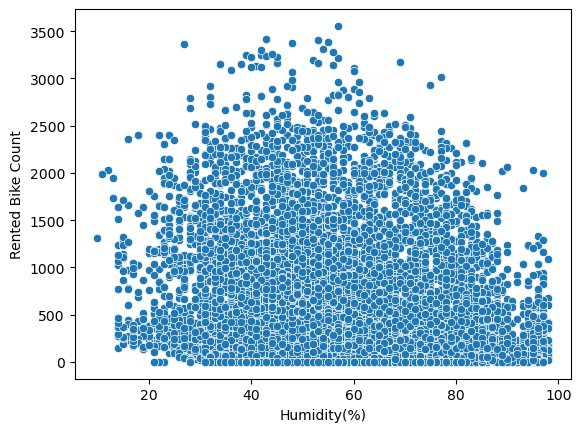

In [686]:
# 습도와 따릉이 대여량 관계
sns.scatterplot(data=df, x="Humidity(%)", y="Rented Bike Count")

---

- Wind speed (m/s)
- 월별 평균 Wind speed로 결측치 대체

In [687]:
# Date에서 월(month) 추출
df['Month'] = pd.to_datetime(df['Date']).dt.month

# 월별 평균 Wind speed 계산
month_avg_wind = df.groupby('Month')['Wind speed (m/s)'].transform('mean')

# 결측치 채우기
df['Wind speed (m/s)'] = df['Wind speed (m/s)'].fillna(month_avg_wind)

# Month 컬럼 제거
df.drop(columns=['Month'], inplace=True)


In [688]:
df.isna().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(째C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(째C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Holiday                      0
Functioning Day              0
Seasons_Autumn               0
Seasons_Spring               0
Seasons_Summer               0
Seasons_Winter               0
dtype: int64

<Axes: xlabel='Wind speed (m/s)', ylabel='Rented Bike Count'>

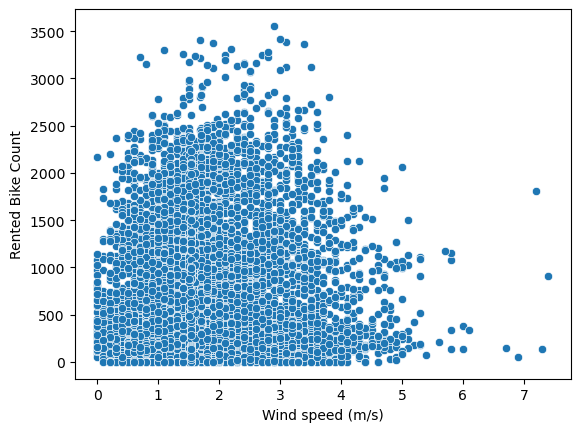

In [689]:
# 대여량과 Wind Speed 관계
sns.scatterplot(data=df, x="Wind speed (m/s)", y="Rented Bike Count")

---

- Visibility

c:\Users\windows\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Visibility (10m)', ylabel='Count'>

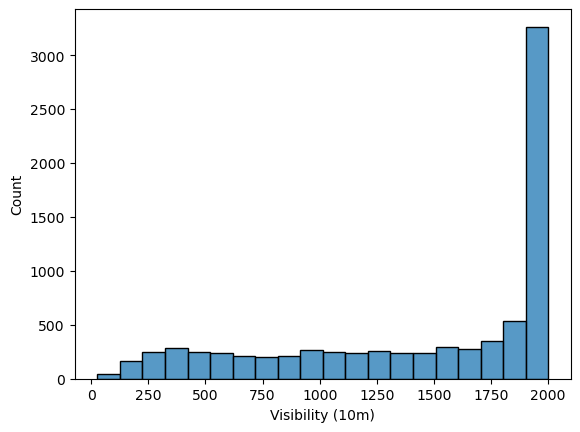

In [690]:
sns.histplot(x=df['Visibility (10m)'])

<Axes: xlabel='Visibility (10m)', ylabel='Rented Bike Count'>

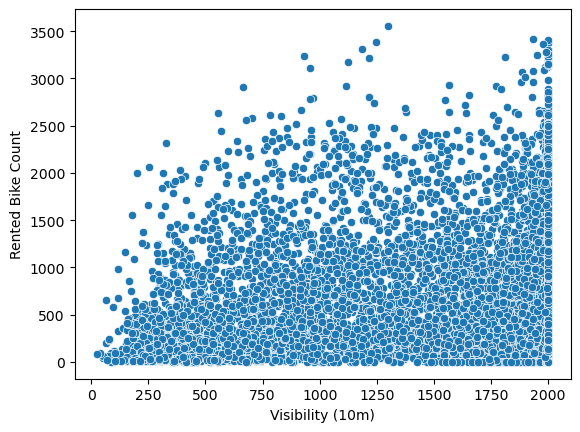

In [691]:
# 대여량과 Visibility 관계
sns.scatterplot(data=df, x="Visibility (10m)", y="Rented Bike Count")

---

- Dew point temperature(째C)

c:\Users\windows\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Dew point temperature(째C)', ylabel='Count'>

c:\Users\windows\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from current font.
  func(*args, **kwargs)
c:\Users\windows\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


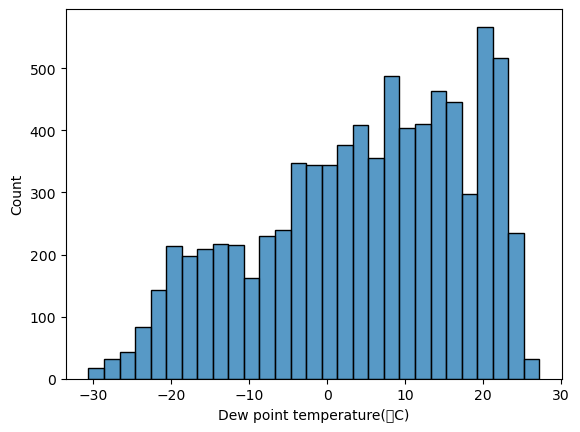

In [692]:
sns.histplot(x=df['Dew point temperature(째C)'])

<Axes: xlabel='Dew point temperature(째C)', ylabel='Rented Bike Count'>

c:\Users\windows\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from current font.
  func(*args, **kwargs)
c:\Users\windows\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


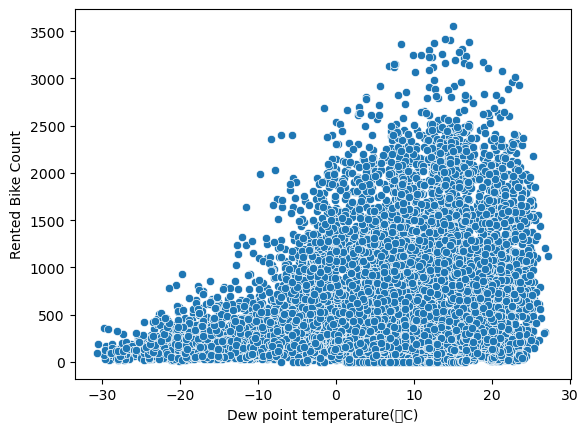

In [693]:
sns.scatterplot(data=df, x="Dew point temperature(째C)", y="Rented Bike Count")

---

- Solar Radiation (MJ/m2)

c:\Users\windows\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Solar Radiation (MJ/m2)', ylabel='Count'>

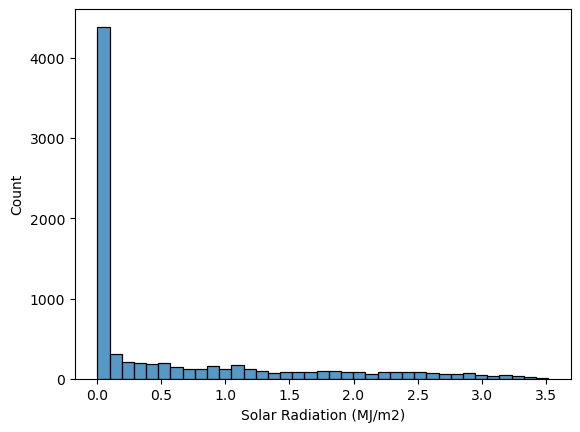

In [694]:
sns.histplot(x=df['Solar Radiation (MJ/m2)'])

---

- Rainfall(mm)

c:\Users\windows\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Rainfall(mm)', ylabel='Count'>

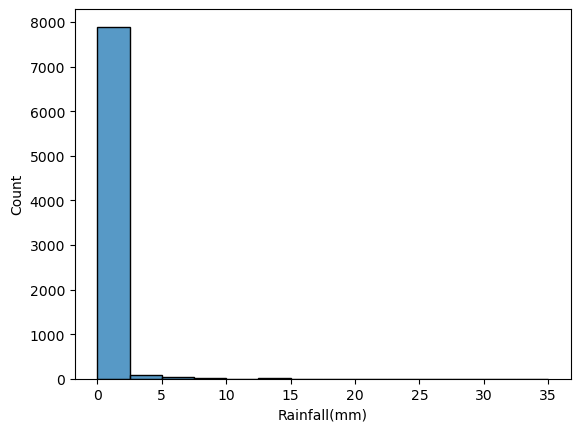

In [695]:
sns.histplot(x=df['Rainfall(mm)'])

<Axes: xlabel='Rainfall(mm)', ylabel='Rented Bike Count'>

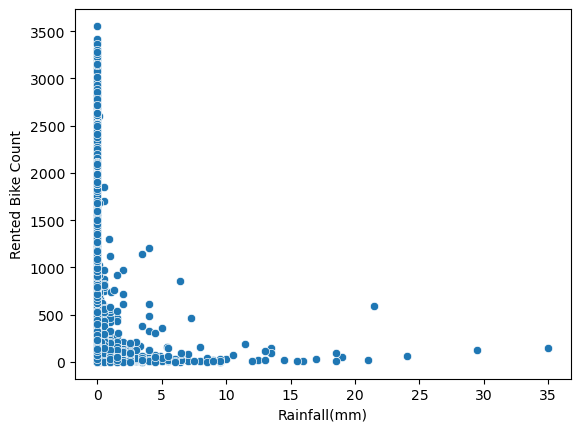

In [696]:
# 따릉이 대여량과의 관계
sns.scatterplot(data=df, x="Rainfall(mm)", y="Rented Bike Count") #강수량과 대여량은 반비례

---

- Snowfall

c:\Users\windows\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Snowfall (cm)', ylabel='Count'>

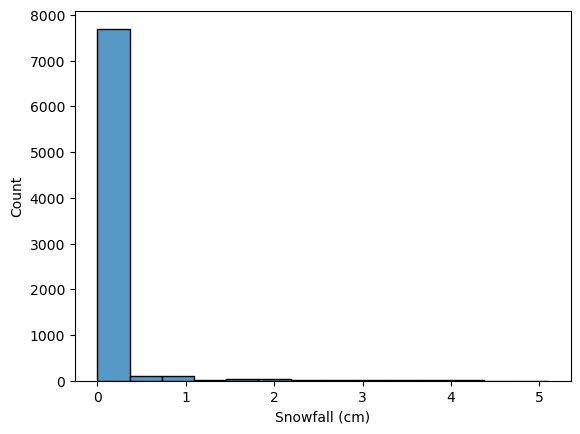

In [697]:
sns.histplot(x=df['Snowfall (cm)'])

<Axes: xlabel='Snowfall (cm)', ylabel='Rented Bike Count'>

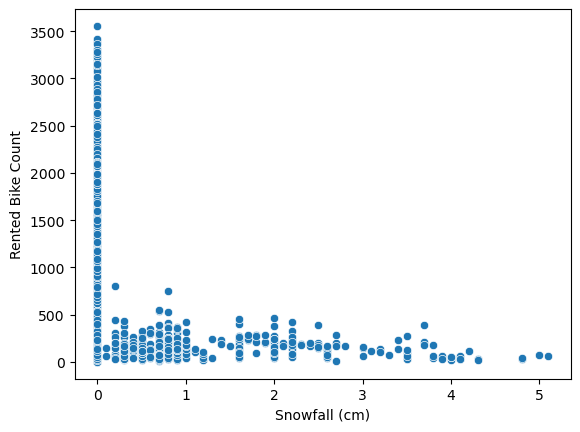

In [698]:
# 따릉이 대여량과의 관계
sns.scatterplot(data=df, x="Snowfall (cm)", y="Rented Bike Count") #대여량과과 반비례

---

- Holiday

In [699]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter
0,2017-12-01,254,0,-5.2,37.0,2.200000,2000,-17.6,0.0,0.0,0.0,No Holiday,Yes,0.0,0.0,0.0,1.0
1,2017-12-01,204,1,-5.5,38.0,0.800000,2000,-17.6,0.0,0.0,0.0,No Holiday,Yes,0.0,0.0,0.0,1.0
2,2017-12-01,173,2,-6.0,39.0,1.000000,2000,-17.7,0.0,0.0,0.0,No Holiday,Yes,0.0,0.0,0.0,1.0
3,2017-12-01,107,3,-6.2,40.0,0.900000,2000,-17.6,0.0,0.0,0.0,No Holiday,Yes,0.0,0.0,0.0,1.0
4,2017-12-01,78,4,-6.0,36.0,1.725223,2000,-18.6,0.0,0.0,0.0,No Holiday,Yes,0.0,0.0,0.0,1.0


In [700]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['Holiday'] = encoder.fit_transform(df['Holiday'])

In [701]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter
0,2017-12-01,254,0,-5.2,37.0,2.200000,2000,-17.6,0.0,0.0,0.0,1,Yes,0.0,0.0,0.0,1.0
1,2017-12-01,204,1,-5.5,38.0,0.800000,2000,-17.6,0.0,0.0,0.0,1,Yes,0.0,0.0,0.0,1.0
2,2017-12-01,173,2,-6.0,39.0,1.000000,2000,-17.7,0.0,0.0,0.0,1,Yes,0.0,0.0,0.0,1.0
3,2017-12-01,107,3,-6.2,40.0,0.900000,2000,-17.6,0.0,0.0,0.0,1,Yes,0.0,0.0,0.0,1.0
4,2017-12-01,78,4,-6.0,36.0,1.725223,2000,-18.6,0.0,0.0,0.0,1,Yes,0.0,0.0,0.0,1.0


---

- Functioning Day

In [702]:
# 인코딩하기

encoder = LabelEncoder()

df['Functioning Day'] = encoder.fit_transform(df['Functioning Day'])

In [703]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter
0,2017-12-01,254,0,-5.2,37.0,2.200000,2000,-17.6,0.0,0.0,0.0,1,1,0.0,0.0,0.0,1.0
1,2017-12-01,204,1,-5.5,38.0,0.800000,2000,-17.6,0.0,0.0,0.0,1,1,0.0,0.0,0.0,1.0
2,2017-12-01,173,2,-6.0,39.0,1.000000,2000,-17.7,0.0,0.0,0.0,1,1,0.0,0.0,0.0,1.0
3,2017-12-01,107,3,-6.2,40.0,0.900000,2000,-17.6,0.0,0.0,0.0,1,1,0.0,0.0,0.0,1.0
4,2017-12-01,78,4,-6.0,36.0,1.725223,2000,-18.6,0.0,0.0,0.0,1,1,0.0,0.0,0.0,1.0


---

# 변수 설정

In [704]:
X = df.drop(columns=['Date', 'Rented Bike Count', 'Hour']) #설명변수
Y = df['Rented Bike Count'] #타겟변수
X.head()
Y.head()

0    254
1    204
2    173
3    107
4     78
Name: Rented Bike Count, dtype: int64

# 데이터에 많은 특성 존재 -> 규제 선형 회귀 모델

In [705]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# 파이프라인으로 규제선형회귀 분석
model_pipe1 = make_pipeline(StandardScaler(), Lasso()) # 표준화, lasso 회귀 적용 하는 파이프라인 정의

## 스케일링: lasso 회귀처럼 규제를 사용하는 모델에서 중요 (특성들의 스케일이 다르면 규제가 효과적으로 적용되지 않을 수 있기 때문에)
model_pipe1

Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())])

In [706]:
#하이퍼파라미터 조절
hyperparam = {'lasso__alpha' : (0.5, 1, 1.5)} # 클수록 강도가 강해짐
grid_model = GridSearchCV(model_pipe1, param_grid = hyperparam, cv=5, 
                          scoring='r2', n_jobs=-1)
grid_model.fit(X, Y)
best_model = grid_model.best_estimator_
best_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=1.5))])

In [707]:
from sklearn.metrics import r2_score, mean_squared_error
Y_pred = best_model.predict(X)

print('학습 능력')
print('R Square : ', r2_score(Y, Y_pred))
print('MSE : ', mean_squared_error(Y, Y_pred))


학습 능력
R Square :  0.4884005480765755
MSE :  221019.47522559375


# 다항 회귀 분석

In [708]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression


model_linear = make_pipeline(PolynomialFeatures(degree=2), LinearRegression()) # 모델정의(다항회귀분석 + 선형회귀분석) : 2차+1차
model_linear.fit(X ,Y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [709]:
Y_pred = model_linear.predict(X)

print('학습 능력')
print('R Square : ', r2_score(Y, Y_pred))
print('MSE : ', mean_squared_error(Y, Y_pred))


학습 능력
R Square :  0.6013577320115698
MSE :  172220.092383389


- model_linear 가 best_model 보다 학습 능력이 뛰어남 -> test 데이터에 model_linear 적용

# 테스트

In [782]:
df2 = data_test.copy()

In [783]:
df2.head()

,Date,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/11/2018,0,5.7,62,2.3,1909,-1.0,0.0,0.0,0.0,Autumn,No Holiday,Yes
1,01/11/2018,1,5.1,65,1.6,1932,-0.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
2,01/11/2018,2,4.4,64,NaN,2000,-1.8,0.0,0.0,0.0,Autumn,No Holiday,Yes
3,01/11/2018,3,4.2,65,0.7,1962,-1.8,0.0,0.0,0.0,Autumn,No Holiday,Yes
4,01/11/2018,4,3.6,70,0.8,1934,-1.3,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [784]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       720 non-null    object 
 1   Hour                       720 non-null    int64  
 2   Temperature(째C)            644 non-null    float64
 3   Humidity(%)                720 non-null    int64  
 4   Wind speed (m/s)           646 non-null    float64
 5   Visibility (10m)           720 non-null    int64  
 6   Dew point temperature(째C)  720 non-null    float64
 7   Solar Radiation (MJ/m2)    720 non-null    float64
 8   Rainfall(mm)               720 non-null    float64
 9   Snowfall (cm)              720 non-null    float64
 10  Seasons                    646 non-null    object 
 11  Holiday                    720 non-null    object 
 12  Functioning Day            720 non-null    object 
dtypes: float64(6), int64(3), object(4)
memory usage: 7

In [785]:
df2.tail()

,Date,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
715,30/11/2018,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,NaN,No Holiday,Yes
716,30/11/2018,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
717,30/11/2018,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
718,30/11/2018,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes
719,30/11/2018,23,1.9,43,1.3,1909,-9.3,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [786]:
df2.isna().sum()

Date                          0
Hour                          0
Temperature(째C)              76
Humidity(%)                   0
Wind speed (m/s)             74
Visibility (10m)              0
Dew point temperature(째C)     0
Solar Radiation (MJ/m2)       0
Rainfall(mm)                  0
Snowfall (cm)                 0
Seasons                      74
Holiday                       0
Functioning Day               0
dtype: int64

In [787]:
# train  데이터에 했던 파생변수 생성/변수 변환 test 셋에 적용

In [788]:
# Seasons 결측치 처리 


df2['Date'] = pd.to_datetime(df2['Date'], format="%d/%m/%Y")

# 월(month) → 계절(Seasons) 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9,10,11]:
        return 'Autumn'
    elif month in [12, 1, 2]:
        return 'Winter'

# Seasons가 결측치(NaN)인 경우에만 채우기
df2['Seasons'] = df2['Seasons'].fillna(df2['Date'].dt.month.apply(get_season))

# 결과 확인
df2['Seasons'].isna().sum()


season_columns = ['Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter']
for col in season_columns:
    if col not in df2.columns:
        df2[col] = 0



In [789]:
# Seasons 변수 원핫인코딩



seasons_encoded = ohe.fit_transform(df2[['Seasons']])

# 변환된 데이터프레임으로 변환
seasons_df2 = pd.DataFrame(seasons_encoded, columns=ohe.get_feature_names_out(['Seasons']))

# 기존 데이터프레임에 추가
df2 = pd.concat([df2, seasons_df2], axis=1)

# 기존 'Seasons' 변수 삭제
df2.drop(columns=['Seasons'], inplace=True)

# 결과 확인
df2.head()


c:\Users\windows\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Date,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Spring,Seasons_Summer,Seasons_Winter,Seasons_Autumn
0,2018-11-01,0,5.7,62,2.3,1909,-1.0,0.0,0.0,0.0,No Holiday,Yes,0,0,0,1.0
1,2018-11-01,1,5.1,65,1.6,1932,-0.9,0.0,0.0,0.0,No Holiday,Yes,0,0,0,1.0
2,2018-11-01,2,4.4,64,NaN,2000,-1.8,0.0,0.0,0.0,No Holiday,Yes,0,0,0,1.0
3,2018-11-01,3,4.2,65,0.7,1962,-1.8,0.0,0.0,0.0,No Holiday,Yes,0,0,0,1.0
4,2018-11-01,4,3.6,70,0.8,1934,-1.3,0.0,0.0,0.0,No Holiday,Yes,0,0,0,1.0


In [790]:
# 온도 결측치 처리



# 전체 Temperature(°C)의 평균 계산
avg_temp = df2['Temperature(째C)'].mean()

# 결측치 채우기
df2['Temperature(째C)'].fillna(avg_temp, inplace=True)




In [791]:
# Humidity 이상치 처리
df2.groupby('Seasons_Autumn')['Humidity(%)'].mean() 
df2.loc[data_train['Humidity(%)'] == 0, 'Humidity(%)'] = 59.967213


C:\Users\windows\AppData\Local\Temp\ipykernel_26824\2574284760.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '59.967213' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df2.loc[data_train['Humidity(%)'] == 0, 'Humidity(%)'] = 59.967213


In [792]:
# Wind Speed 결측치 처리

# Date에서 월(month) 추출
df2['Month'] = pd.to_datetime(df2['Date']).dt.month

# 월별 평균 Wind speed 계산
month_avg_wind = df2.groupby('Month')['Wind speed (m/s)'].transform('mean')

# 결측치 채우기
df2['Wind speed (m/s)'] = df2['Wind speed (m/s)'].fillna(month_avg_wind)

# Month 컬럼 제거
df2.drop(columns=['Month'], inplace=True)

In [793]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df2['Holiday'] = encoder.fit_transform(df2['Holiday'])



encoder = LabelEncoder()

df2['Functioning Day'] = encoder.fit_transform(df2['Functioning Day'])

In [794]:
df2.head()

,Date,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Spring,Seasons_Summer,Seasons_Winter,Seasons_Autumn
0,2018-11-01,0,5.7,62.0,2.300000,1909,-1.0,0.0,0.0,0.0,0,1,0,0,0,1.0
1,2018-11-01,1,5.1,65.0,1.600000,1932,-0.9,0.0,0.0,0.0,0,1,0,0,0,1.0
2,2018-11-01,2,4.4,64.0,1.396285,2000,-1.8,0.0,0.0,0.0,0,1,0,0,0,1.0
3,2018-11-01,3,4.2,65.0,0.700000,1962,-1.8,0.0,0.0,0.0,0,1,0,0,0,1.0
4,2018-11-01,4,3.6,70.0,0.800000,1934,-1.3,0.0,0.0,0.0,0,1,0,0,0,1.0


In [795]:
df2.isna().sum()

Date                         0
Hour                         0
Temperature(째C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(째C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Holiday                      0
Functioning Day              0
Seasons_Spring               0
Seasons_Summer               0
Seasons_Winter               0
Seasons_Autumn               0
dtype: int64

---

# test 셋에 모델 적용하기

In [796]:
# 계절 순서 재배열
X2 = df2[['Temperature(째C)','Humidity(%)','Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(째C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
           'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter']]

In [797]:
X2.head()

,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter
0,5.7,62.0,2.300000,1909,-1.0,0.0,0.0,0.0,0,1,1.0,0,0,0
1,5.1,65.0,1.600000,1932,-0.9,0.0,0.0,0.0,0,1,1.0,0,0,0
2,4.4,64.0,1.396285,2000,-1.8,0.0,0.0,0.0,0,1,1.0,0,0,0
3,4.2,65.0,0.700000,1962,-1.8,0.0,0.0,0.0,0,1,1.0,0,0,0
4,3.6,70.0,0.800000,1934,-1.3,0.0,0.0,0.0,0,1,1.0,0,0,0


In [798]:
Y_test_pred = model_linear.predict(X2)